In [1]:
import numpy as np
import pandas as pd
import os
import json
import ast
from IPython.display import display
from pathlib import Path
# 设置pandas显示选项，增加最大列宽和禁用换行
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', None)

# 获取所有实验文件夹
results_base_dir = "../results"
experiment_folders = [d for d in os.listdir(results_base_dir) 
                     if os.path.isdir(os.path.join(results_base_dir, d)) and d.startswith('experiment_')]
experiment_id = None
experiment_id = "experiment_20251212_111150"
# experiment_root = "experiment_20251210_180857"
# experiment_id = f'aip_rag_perf/{experiment_root}'
if not experiment_id:
    latest_experiment = max(experiment_folders)
    experiment_folder = os.path.join(results_base_dir, latest_experiment)
    print(f"\n选择最新的实验文件夹: {latest_experiment}")
else:
    experiment_folder = os.path.join(results_base_dir, experiment_id)
    print(f"\n选择提供的的实验文件夹: {experiment_id}")
csv_files = [f for f in os.listdir(experiment_folder) 
                 if f.endswith('.csv') and 'rag_evaluation' in f]
csv_df = pd.read_csv(os.path.join(experiment_folder, csv_files[0]))

# 修复字符串格式的列表数据
def safe_parse_list(val):
    """安全地将字符串转换为列表"""
    if pd.isna(val) or val == 'nan':
        return []
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        try:
            # 尝试使用ast.literal_eval解析
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            try:
                # 尝试使用json.loads解析
                return json.loads(val)
            except json.JSONDecodeError:
                return []
    return []

# 应用转换到相关列
list_columns = ['total_files_searched_list', 'grep_files_count_list', 'grep_patterns_list', 'no_matches_count_list']
for col in list_columns:
    if col in csv_df.columns:
        csv_df[col] = csv_df[col].apply(safe_parse_list)



选择提供的的实验文件夹: experiment_20251212_111150


In [2]:
intermediate_metrics = [col for col in csv_df.columns if col.startswith('intermediate_') or '_diff' in col]
retrieval_metrics = ['question_id', 'ndcg', 'ncg', 'mrr', 'ndcg_at_3', 'ndcg_at_5'] + intermediate_metrics
QA_metrics = ['question_id', 'llm_judge_score'] + intermediate_metrics
Both_metrics = ['question_id', 'overall_score', 'metric_with_token', 'llm_judge_score', 'ndcg', 'ncg', 'mrr', 'ndcg_at_3', 'ndcg_at_5'] + intermediate_metrics
reject_metrics = ['question_id', 'overall_score', 'rejection_recall']
print_metrics = ['metric_with_token','perf_score','overall_score', 'llm_judge_score','rejection_recall','ndcg']
for col in print_metrics:
    if col in csv_df.columns:
        print(f"\n{col} 统计:")
        print(f"平均值: {csv_df[col].mean():.4f}")
### 查看csv, 按照不同question_type分组
print("按question_type分组统计:")
numeric_cols = csv_df.select_dtypes(include=['number']).columns
grouped = csv_df.groupby('question_type')

print("Overall statistics: \n")
display(csv_df.describe().loc[['mean', '50%']])
print('Statistics for each question type: \n')
result = grouped.agg({
    col: ['mean'] for col in numeric_cols
})
print(result)

# for question_type, group in grouped:
#     print(f"\n----------Question Type: {question_type}-----------")
#     if question_type == 'Ranking':
#         print(group[retrieval_metrics])
#     elif question_type == 'QA':
#         print(group[QA_metrics])
#     elif question_type == 'Refusal' or question_type == 'refusal':
#         print(group[reject_metrics])
#     else:
#         print(group[Both_metrics])


metric_with_token 统计:
平均值: 0.1665

perf_score 统计:
平均值: 0.2583

overall_score 统计:
平均值: 0.1298

llm_judge_score 统计:
平均值: 0.0412

rejection_recall 统计:
平均值: 0.0000

ndcg 统计:
平均值: 0.3204
按question_type分组统计:
Overall statistics: 



,metric_with_token,perf_score,overall_score,llm_judge_score,rejection_recall,ndcg,ncg,mrr,pre_search_ndcg,pre_search_mrr,...,average_search_agent_token,num_search_calls,total_num_tokens,total_num_input_tokens,total_num_output_tokens,execution_time_seconds,ndcg_at_3,ndcg_at_5,retrieved_count,refusal_choice
mean,0.166502,0.258275,0.129792,0.041176,0.0,0.320388,0.323667,0.396667,0.633514,0.810667,...,0.0,0.0,2625.076923,2385.692308,239.384615,4.357096,0.355755,0.338778,3.18,NaN
50%,0.094091,0.265920,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.943594,1.000000,...,0.0,0.0,1748.000000,1505.500000,266.000000,4.452000,0.000000,0.000000,2.00,NaN


Statistics for each question type: 

                                         metric_with_token perf_score overall_score llm_judge_score rejection_recall      ndcg       ncg       mrr pre_search_ndcg pre_search_mrr  ... average_search_agent_token num_search_calls total_num_tokens total_num_input_tokens total_num_output_tokens execution_time_seconds ndcg_at_3 ndcg_at_5 retrieved_count refusal_choice
                                                      mean       mean          mean            mean             mean      mean      mean      mean            mean           mean  ...                       mean             mean             mean                   mean                    mean                   mean      mean      mean            mean           mean
question_type                                                                                                                                                                      ...                                                   

In [3]:
import textwrap

def show_sample_readable(sample_json_path, question_id, width=100):
    with open(sample_json_path, 'r', encoding='utf-8') as f:
                sample_data = json.load(f)
            
    print(f"\n{'='*80}")
    print(f"简化Sample JSON for {question_id}")
    print(f"{'='*80}")
    
    # 提取sample_info中的字段
    if 'sample_info' in sample_data:
        sample_info = sample_data['sample_info']
        # print(f"\n--- question_id ---")
        # print(sample_info.get('question_id', 'N/A'))
        
        # print(f"\n--- user_query ---")
        # print(sample_info.get('user_query', 'N/A'))
        
        # print(f"\n--- ideal ---")
        # print(sample_info.get('ideal', 'N/A'))
        
        print(f"\n--- question_type ---")
        print(sample_info.get('question_type', 'N/A'))
        
        # print(f"\n--- expected_context_ids ---")
        # print(sample_info.get('expected_context_ids', []))
    
    # # 提取response
    # print(f"\n--- response ---")
    # response = sample_data.get('response', 'N/A')
    # print(response)
    
    # 提取messages中的content和tool_result.result
    if 'messages' in sample_data:
        print(f"\n--- Messages详情 ---")
        for idx, msg in enumerate(sample_data['messages']):
            msg_type = msg.get('type', 'unknown')
            
            # 提取content字段（自动换行）
            if 'content' in msg and msg['content']:
                print(f"\n[Message {idx+1}] Type: {msg_type}, Role: {msg.get('role', 'N/A')}")
                print(f"--- content ---")
                # 使用textwrap进行自动换行，宽度设置为30字符
                wrapped_content = textwrap.fill(msg['content'], width=width, 
                                                break_long_words=True, 
                                                break_on_hyphens=True)
                print(wrapped_content)
            # 提取tool_call.arguments.keywords字段（自动换行）
            if msg_type == 'tool_call' and 'tool_call' in msg:
                tool_call = msg['tool_call']
                if 'arguments' in tool_call and 'keywords' in tool_call['arguments']:
                    print(f"\n[Message {idx+1}] Type: {msg_type}")
                    print(f"--- tool_call.arguments.keywords ---")
                    keywords_str = tool_call['arguments']['keywords']
                    for line in keywords_str:
                        print(line)
                if 'arguments' in tool_call and 'reason_refine' in tool_call['arguments']:
                    print(f"\n[Message {idx+1}] Type: {msg_type}")
                    keywords_str = tool_call['arguments']['reason_refine']
                    print(keywords_str)
            # 提取tool_result.result字段（自动换行）
            if msg_type == 'tool_result' and 'tool_result' in msg:
                tool_result = msg['tool_result']
                if 'result' in tool_result:
                    print(f"\n[Message {idx+1}] Type: {msg_type}")
                    print(f"--- tool_result.result ---")
                    result_str = tool_result['result']
                    # 对于长文本进行自动换行
                    wrapped_result = textwrap.fill(result_str, width=width,
                                                    break_long_words=True,
                                                    break_on_hyphens=True)
                    print(wrapped_result)

In [4]:

def show_details_for_question(corpus_path, question_id, question_df, show_context=False, show_processed_json=False, show_sample_json=False, show_simple_sample=False, width=30):
    detailed_metrics = ['question_id', 'overall_score', 'metric_with_token', 'perf_score', 'pre_search_ndcg', 'ndcg', 'pre_search_retrieved_ids', 'total_num_tokens', 'retrieved_id', 'expected_retrieval_id', 
    'user_query', 'direct_answer', 'gt_answer', 'response_raw']
    for metric in detailed_metrics:
        print(f"\n--- {metric} ---")
        print(question_df[metric].item())
    if 'intermediate_ncg' in question_df.columns:
        print(f"\n--- intermediate_ncg ---")
        print(question_df['intermediate_ncg'].item())
    if 'num_read_file_lines_calls' in question_df.columns:
        print(f"\n--- num_read_file_lines_calls ---")
        print(question_df['num_read_file_lines_calls'].item())
    ### 展示llm分数及原因
    print(f'Reason for LLM Judge: {question_df["llm_judge_reasoning"].item()}, {question_df["llm_judge_choice"].item()}')
    print(question_df['llm_judge_reasoning'].item())
    ### 根据question_id读取expected_doc_content，retrieved_docs_content
    if show_context:
        expected_ids = question_df['expected_retrieval_id'].item().split(';')
        print("\n--- Expected Document Contents ---")
        for doc_id in expected_ids:
            doc_path = Path(corpus_path) / f"{doc_id}.txt"
            if doc_path.exists():
                with open(doc_path, 'r') as f:
                    content = f.read()
                print(f"\nDocument ID: {doc_id}\nContent:\n{content}")
            else:
                print(f"Document ID: {doc_id} not found.")
        if question_df['retrieved_id'].item() == 'nan' or type(question_df['retrieved_id'].item()) == float:
            print("\nNo retrieved documents.")
        elif len(question_df['retrieved_id'].item()) == 0:
            print("\nNo retrieved documents.")
        else:
            retrieved_ids = question_df['retrieved_id'].item().split(';')
            print("\n--- Retrieved Document Contents ---")
            for doc_id in retrieved_ids:
                doc_path = Path(corpus_path) / f"{doc_id}.txt"
                if doc_path.exists():
                    with open(doc_path, 'r') as f:
                        content = f.read()
                    print(f"\nDocument ID: {doc_id}\nContent:\n{content}")
                else:
                    print(f"Document ID: {doc_id} not found.")
    ### 根据question_id查看processed_json
    if show_processed_json:
        processed_json_path = Path(experiment_folder) / "processed_json" / f"processed_{question_id}.json"
        if processed_json_path.exists():
            with open(processed_json_path, 'r') as f:
                processed_json = f.read()
            print(f"\n--- Processed JSON for {question_id} ---\n{processed_json}")
        else:
            print(f"Processed JSON for {question_id} not found.")
    ### 根据question_id查看sample_json
    if show_sample_json:
        sample_json_path = Path(experiment_folder) / "samples" / f"sample_{question_id}.json"
        if sample_json_path.exists():
            with open(sample_json_path, 'r') as f:
                sample_json = f.read()
            print(f"\n--- Sample JSON for {question_id} ---\n{sample_json}")
        else:
            print(f"Sample JSON for {question_id} not found.")
    
    ### 根据question_id查看简化版sample_json，提取关键字段
    if show_simple_sample:
        sample_json_path = Path(experiment_folder) / "samples" / f"sample_{question_id}.json"
        if sample_json_path.exists():
            show_sample_readable(sample_json_path, question_id=question_id, width=width)
            
            print(f"\n{'='*80}\n")
        else:
            print(f"Sample JSON for {question_id} not found.")


In [5]:
### 查看csv，按overall_score排序
sorted_df = csv_df.sort_values('overall_score', ascending=False)
print(sorted_df)
question_id_list = sorted_df[sorted_df['overall_score'] < 0.51]['question_id']
print(list(question_id_list))
score_0 = sorted_df[sorted_df['overall_score'] == 0]['question_id']
print(list(score_0))

                           question_id                             question_type  metric_with_token  perf_score  overall_score  llm_judge_score  rejection_recall      ndcg       ncg       mrr  ...  ndcg_at_3  ndcg_at_5  retrieved_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [6]:
def has_irrelevant_docs(row):
    """检查retrieved_id中是否包含不在expected_retrieval_id中的内容"""
    retrieved = row['retrieved_id']
    expected = row['expected_retrieval_id']
    
    # 处理空值情况
    if pd.isna(retrieved) or retrieved == 'nan' or retrieved == '' or type(retrieved) == float:
        return False
    if pd.isna(expected) or expected == 'nan' or expected == '':
        return False
    
    # 分割成列表
    retrieved_list = set(str(retrieved).split(';'))
    expected_list = set(str(expected).split(';'))
    
    # 检查是否有retrieved中的ID不在expected中
    irrelevant_docs = retrieved_list - expected_list
    return len(irrelevant_docs) > 0

In [7]:
# print('Total failure case: ', len(question_id_list))
# list_of_positive_diff_ids = list(sorted_df[sorted_df['question_id'].isin(question_id_list) & (sorted_df['ncg_inter-final_diff'] > 0)]['question_id'])
# count_positive_diff = sorted_df[sorted_df['question_id'].isin(list_of_positive_diff_ids)].shape[0]
# print(f'搜到但agents忽略了部分: {count_positive_diff}')
# print('corresponding question_ids: ', list_of_positive_diff_ids)

# list_of_positive_diff_search_ids = list(sorted_df[sorted_df['question_id'].isin(question_id_list) & (sorted_df['ncg_inter-search_agent_diff'] > 0)]['question_id'])
# count_positive_diff = sorted_df[sorted_df['question_id'].isin(list_of_positive_diff_search_ids)].shape[0]
# print(f'搜到但search agent忽略了部分: {count_positive_diff}')
# print('corresponding question_ids: ', list_of_positive_diff_search_ids)

# list_of_positive_diff_rag_ids = list(sorted_df[sorted_df['question_id'].isin(question_id_list) & (sorted_df['ncg_search_agent-final_diff'] > 0)]['question_id'])
# count_positive_diff = sorted_df[sorted_df['question_id'].isin(list_of_positive_diff_rag_ids)].shape[0]
# print(f'搜到但rag agent忽略了部分: {count_positive_diff}')
# print('corresponding question_ids: ', list_of_positive_diff_rag_ids)

# list_of_positive_count_zero_diff_ids = list(sorted_df[sorted_df['question_id'].isin(question_id_list) & 
#                                                   ((sorted_df['grep_files_count_list'].apply(lambda x: sum(x)) - 
#                                                     sorted_df['no_matches_count_list'].apply(lambda x: sum(x))) == 0)]['question_id'])
# count_zero_diff = sorted_df[sorted_df['question_id'].isin(list_of_positive_count_zero_diff_ids)].shape[0]
# print(f'所有grep尝试均未搜到: {count_zero_diff}')
# print('corresponding question_ids: ', list_of_positive_count_zero_diff_ids)

# list_of_nonzero_count_ids = list(sorted_df[sorted_df['question_id'].isin(question_id_list) &
#     (sorted_df['grep_files_count_list'].apply(lambda x: sum(x)) -
#      sorted_df['no_matches_count_list'].apply(lambda x: sum(x)) != 0) &
#     (sorted_df['total_files_searched_list'].apply(lambda x: sum(x)) == 0)]['question_id'])
# count_condition = sorted_df[sorted_df['question_id'].isin(list_of_nonzero_count_ids)].shape[0]

# print(f'搜到但search agent说没搜到: {count_condition}')
# print('corresponding question_ids: ', list_of_nonzero_count_ids)

# list_of_not_fully_searched = list(sorted_df[
#     sorted_df['question_id'].isin(question_id_list) & 
#     (sorted_df['intermediate_ncg'].apply(lambda x: x < 1))]['question_id'])
# not_fully_searched = sorted_df[sorted_df['question_id'].isin(list_of_not_fully_searched)].shape[0]

# print(f'搜索不全: {not_fully_searched}')
# print('corresponding question_ids: ', list_of_not_fully_searched)

# list_of_irrelevant_ids = list(sorted_df[
#     sorted_df['question_id'].isin(question_id_list) & 
#     sorted_df.apply(has_irrelevant_docs, axis=1)]['question_id'])
# irrelevant = sorted_df[sorted_df['question_id'].isin(list_of_irrelevant_ids)].shape[0]

# print(f'列出了不相关的: {irrelevant}')
# print('corresponding question_ids: ', list_of_irrelevant_ids)

# other_ids = set(list(question_id_list)) - set(list_of_positive_diff_ids)\
#       - set(list_of_positive_diff_rag_ids) - set(list_of_positive_diff_search_ids)\
# - set(list_of_positive_count_zero_diff_ids) - set(list_of_nonzero_count_ids) \
# - set(list_of_not_fully_searched) - set(list_of_irrelevant_ids)
# print('其他情况： ', len(other_ids))
# print('corresponding question_ids: ', other_ids)


In [8]:
# check_id_list = other_ids
# check_id_list = ['crud_sample_0029']
check_id_list = list(sorted_df['question_id'])
# check_id_list = list(score_0)
print('Checking question: ', len(check_id_list))
if not check_id_list:
    check_id_list = question_id_list
print_list = ['question_id', 'question_type', 'user_query', 'overall_score', 'direct_answer', 'gt_answer', 'rejection_recall',
'llm_judge_score', 'retrieved_id', 'expected_retrieval_id', 'ndcg', 'mrr', 'pre_search_ndcg', 'pre_search_retrieved_ids']

for question in list(check_id_list):
    print('\n')
    print(question)
    for col in (print_list):
        if col in sorted_df.columns:
            print(f'{col}: ', [sorted_df[sorted_df['question_id'] == question][col].item()])
        

Checking question:  52


codexglue_adv_09d42983b02bf2ca
question_id:  ['codexglue_adv_09d42983b02bf2ca']
question_type:  ['codexglue-adv-retrieval']
user_query:  ["Find the code function that: This rolls up the feature functions above and returns a single dict.\n\n    NOTE: this doesn't calculate the CDPP to save time since binning and\n    smoothing takes a while for dense light curves.\n\n    Parameters\n    ----------\n\n    times,mags,errs : np.array\n        The input mag/flux time-series to calculate CDPP for.\n\n    magsarefluxes : bool\n        If True, indicates `mags` is actually an array of flux values.\n\n    stetson_weightbytimediff : bool\n        If this is True, the Stetson index for any pair of mags will be\n        reweighted by the difference in times between them using the scheme in\n        Fruth+ 2012 and Zhange+ 2003 (as seen in Sokolovsky+ 2017)::\n\n            w_i = exp(- (t_i+1 - t_i)/ delta_t )\n\n    Returns\n    -------\n\n    dict\n        Returns a dict 

In [9]:
# check_id_list = other_ids
# check_id_list = ['crud_sample_0029']
check_id_list = list(question_id_list)
# check_id_list = list(score_0)
print('Checking question: ', len(check_id_list))
if not check_id_list:
    check_id_list = question_id_list
print_list = ['question_id', 'question_type', 'user_query', 'overall_score', 'metric_with_token', 'direct_answer', 'gt_answer', 
'llm_judge_score', 'llm_judge_choice', 'llm_judge_reasoning', 'retrieved_id', 'expected_retrieval_id', 'ndcg', 'mrr']
# Token相关字段
token_columns = ['rag_agent_input_tokens', 'rag_agent_output_tokens', 'rag_agent_tokens',
                 'search_agent_input_tokens', 'search_agent_output_tokens', 'search_agent_tokens_total',
                 'total_num_tokens', 'total_num_input_tokens', 'total_num_output_tokens',
                 'num_search_calls']
intermediate_metrics = ['search_agent_ndcg', 'search_agent_ncg', 'ndcg_search_agent-final_diff', 'ncg_search_agent-final_diff', 'ndcg_inter-search_agent_diff', 'ncg_inter-search_agent_diff', 'intermediate_ndcg', 'ndcg', 'ndcg_inter-final_diff', 'intermediate_ncg', 'ncg', 'ncg_inter-final_diff', 'total_files_searched_list',
       'grep_files_count_list', 'grep_patterns_list', 'no_matches_count_list',
       'num_tasks', 'num_read_file_lines_calls']
for question in list(check_id_list):
    print('\n')
    print(question)
    for col in (print_list + token_columns + intermediate_metrics):
        if col in sorted_df.columns:
            print(f'{col}: ', [sorted_df[sorted_df['question_id'] == question][col].item()])
        

Checking question:  49


codexglue_adv_79062a0ed9ab5ea8
question_id:  ['codexglue_adv_79062a0ed9ab5ea8']
question_type:  ['codexglue-adv-retrieval']
user_query:  ['Find the code function that: Try loading given cache file.']
overall_score:  [0.5]
metric_with_token:  [0.4247542857142858]
direct_answer:  [nan]
gt_answer:  ['def Func(arg_0, arg_1, *arg_2, **arg_3):\n        """Try loading given cache file."""\n        try:\n            arg_4 = shelve.open(arg_1)\n            return arg_0(arg_1, arg_4, *arg_2, **arg_3)\n        except OSError as e:\n            logger.debug("Loading {0} failed".format(arg_1))\n            raise e']
llm_judge_score:  [nan]
llm_judge_choice:  [nan]
llm_judge_reasoning:  [nan]
retrieved_id:  ['codexglue_adv_f6af654b4491a647;codexglue_adv_a71ce5a425c2894e;codexglue_adv_79062a0ed9ab5ea8;codexglue_adv_b2f0c1cb1f364141;codexglue_adv_6ee9de372881beb1;codexglue_adv_2fdd3a1ffadedec3;codexglue_adv_64131eedea39538f;codexglue_adv_92c8d5e4eb32cfa1']
expected_retrieval_i

In [10]:
from collections import Counter
question_ids = list(sorted_df['question_id'])
cnt_supposed_search = 0
cnt_supposed_rag = 0
num_call_search_agent = []
for question_id in question_ids:
    question_df = sorted_df[sorted_df['question_id'] == question_id]
    processed_json_path = Path(experiment_folder) / "processed_json" / f"processed_{question_id}.json"
    if processed_json_path.exists():
        with open(processed_json_path, 'r') as f:
            processed_json = f.read()
        processed_json = json.loads(processed_json)
        num_call_search_agent.append(len(processed_json))
        if len(processed_json) == 0:
            cnt_supposed_search += 1
            print(f"Question {question_id} supposed to use search agent but didn't.")
    else:
        num_call_search_agent.append(0)
        print(f"Processed JSON for {question_id} not found.")
        cnt_supposed_rag += 1
print(f"Total questions searching agent supposed to use tools but didn't: {cnt_supposed_search}")
print(f"Total questions rag agent supposed to use tools but didn't: {cnt_supposed_rag}")
print(f"Number of calls to search agent: {Counter(num_call_search_agent)}")
# print(f'num_read_file_lines_calls: {Counter(sorted_df["num_read_file_lines_calls"])}')


Processed JSON for codexglue_adv_09d42983b02bf2ca not found.
Processed JSON for mdlr_test_query_755 not found.
Processed JSON for unnormal_sample_0000 not found.
Processed JSON for codexglue_adv_79062a0ed9ab5ea8 not found.
Processed JSON for code_retrieval_sample_0002 not found.
Processed JSON for limit_sample_0000 not found.
Processed JSON for conflict_sample_0001 not found.
Processed JSON for diff_language_1doc_english0002 not found.
Processed JSON for diff_language_1doc_traditional0001 not found.
Processed JSON for diff_language_1doc_traditional0002 not found.
Processed JSON for no_original_keywords_0000 not found.
Processed JSON for crud_sample_0002 not found.
Processed JSON for diff_language_1doc_pinyin0001 not found.
Processed JSON for diff_language_1doc_typo0001 not found.
Processed JSON for crud_sample_0001 not found.
Processed JSON for crud_sample_0004 not found.
Processed JSON for complex_logic_2doc_sample_0001 not found.
Processed JSON for complex_logic_1doc_sample_0001 not 

In [11]:
### 根据question_id读取对应query，direct_answer, response_raw， retrieved_docs_id，expected_docs_id
# question_ids = ['crud_sample_0058']
# question_ids = list(question_id_list)
question_ids = list(score_0)
for question_id in question_ids:
    question_df = sorted_df[sorted_df['question_id'] == question_id]
    corpus_path = '/home/dyvm6xra/dyvm6xrauser44/wujiamin/AgenticRAG/agents-in-python/corpus/CRUD_80000'
    if question_df['question_type'].item() == 'refusal' or question_df['question_type'].item() == 'Refusal':
        continue

    show_details_for_question(corpus_path, question_id, question_df, \
                            #   show_context=True, \
                              # show_processed_json=True, \
                              # show_sample_json=True, \
                              show_simple_sample=True,
                              width=50
                            )




--- question_id ---
mdlr_test_query_251

--- overall_score ---
0.0

--- metric_with_token ---
0.0583371428571428

--- perf_score ---
0.20418

--- pre_search_ndcg ---
0.0

--- ndcg ---
0.0

--- pre_search_retrieved_ids ---
mdlr_query_760_pos_0;mdlr_query_295_neg_4;mdlr_query_100_neg_2;mdlr_query_423_neg_3;mdlr_query_655_neg_2;mdlr_query_760_pos_0;mdlr_query_792_pos_0;mdlr_query_363_neg_4

--- total_num_tokens ---
3825

--- retrieved_id ---
mdlr_query_760_pos_0;mdlr_query_760_pos_0;mdlr_query_423_neg_3;mdlr_query_792_pos_0;mdlr_query_363_neg_4;mdlr_query_295_neg_4;mdlr_query_100_neg_2;mdlr_query_655_neg_2

--- expected_retrieval_id ---
mdlr_query_251_pos_0

--- user_query ---
提升自身100%攻击力的招数是否真的能够一次秒杀掉一头灭世双头龙？

--- direct_answer ---
nan

--- gt_answer ---
nan

--- response_raw ---
{
  "answer": "",
  "sources": ["/home/dyvm6xra/dyvm6xrauser44/wujiamin/AgenticRAG/agents-in-python/corpus_split_periods/MDLR_ZH_test_split_period/mdlr_query_760_pos_0.txt", "/home/dyvm6xra/dyvm6xrauser44/wujia

# Token 使用和执行时间分析

查看每个sample的token使用情况（RAG agent和Search agent）以及execution time

In [12]:
# 选择需要查看的列：question_id, execution_time, token相关列
token_cols = ['question_id', 'total_num_tokens', 'execution_time_seconds', 
              "total_num_input_tokens", "total_num_output_tokens",
              "rag_agent_input_tokens","rag_agent_output_tokens","rag_agent_tokens","rag_agent_total_tokens",
               "search_agent_input_tokens","search_agent_output_tokens","search_agent_tokens_total","search_agent_total_tokens", 
              'average_search_agent_token', 'num_search_calls']

# 检查这些列是否存在
available_token_cols = [col for col in token_cols if col in csv_df.columns]

if len(available_token_cols) > 1:  # 至少有question_id和其他一列
    token_df = csv_df[available_token_cols].copy()
    
    print(f"Token和时间统计 (共 {len(token_df)} 个样本):")
    print("="*100)
    # display(token_df.head(20))
    
    # 显示统计信息
    print(f"\n统计摘要:")
    print(f"{'='*100}")
    if 'execution_time_seconds' in token_df.columns:
        print(f"平均执行时间: {token_df['execution_time_seconds'].mean():.2f}秒")
        print(f"最长执行时间: {token_df['execution_time_seconds'].max():.2f}秒")
        print(f"最短执行时间: {token_df['execution_time_seconds'].min():.2f}秒")
    
    if 'total_num_tokens' in token_df.columns:
        total_estimated_token = token_df['total_num_input_tokens'] / 20 + token_df['total_num_output_tokens']
        print(f"\n平均估计处理时间: {total_estimated_token.mean()/20:.2f}秒")
        print(f"最长估计处理时间: {total_estimated_token.max()/20:.2f}秒")
        print(f"最短估计处理时间: {total_estimated_token.min()/20:.2f}秒")
        print(f"\n平均token数: {total_estimated_token.mean():.2f} tokens")
        print(f"最长token数: {total_estimated_token.max():.2f} tokens")
        print(f"最短token数: {total_estimated_token.min():.2f} tokens")
    if 'rag_agent_total_tokens' in token_df.columns:
        print(f"\n平均 RAG Agent Tokens: {token_df['rag_agent_total_tokens'].mean():.0f}")
    
    if 'average_search_agent_token' in token_df.columns:
        print(f"\n平均每次 Search Agent调用: {token_df['average_search_agent_token'].mean():.0f} tokens")
    
    if 'num_search_calls' in token_df.columns:
        print(f"\nSearch Agent调用次数统计: {len(token_df[token_df['num_search_calls'] > 0])}")
        print(f"平均 Search Agent调用次数: {token_df['num_search_calls'].mean():.1f}")
        print(f"最多调用次数: {token_df['num_search_calls'].max():.0f}")
        print(f"没有调用的比例: {len(token_df[token_df['num_search_calls'] == 0]) * 100 / len(token_df['num_search_calls']):.1f}%")
else:
    print("⚠ Token相关列不存在，请先运行 process_intermediate.py 处理数据")
    print(f"可用的列: {csv_df.columns.tolist()}")


Token和时间统计 (共 52 个样本):

统计摘要:
平均执行时间: 4.36秒
最长执行时间: 10.53秒
最短执行时间: 1.24秒

平均估计处理时间: 17.93秒
最长估计处理时间: 58.67秒
最短估计处理时间: 1.71秒

平均token数: 358.67 tokens
最长token数: 1173.50 tokens
最短token数: 34.30 tokens

平均 RAG Agent Tokens: 359

平均每次 Search Agent调用: 0 tokens

Search Agent调用次数统计: 0
平均 Search Agent调用次数: 0.0
最多调用次数: 0
没有调用的比例: 100.0%


In [13]:
# 输出Pre-search NDCG < 0.8 且 Search Agent 调用次数为 0 的样本的overall_score及pre_search_ndcg
if 'overall_score' in csv_df.columns and 'pre_search_ndcg' in csv_df.columns and 'num_search_calls' in csv_df.columns:
    # 筛选符合条件的样本
    filtered_df = csv_df[(csv_df['pre_search_ndcg'] < 0.8) & (csv_df['num_search_calls'] == 0)]
    
    if len(filtered_df) > 0:
        score_comparison = filtered_df[['question_id', 'overall_score', 'pre_search_ndcg', 'num_search_calls']].copy()
        
        print(f"Pre-search NDCG < 0.8 且 Search Agent 调用次数为 0 的样本 (共 {len(filtered_df)} 个):")
        print("="*100)
        display(score_comparison)
        
        # 统计信息
        print(f"\n统计摘要:")
        print(f"平均 overall_score: {filtered_df['overall_score'].mean():.4f}")
        print(f"平均 pre_search_ndcg: {filtered_df['pre_search_ndcg'].mean():.4f}")
    else:
        print("没有找到符合条件的样本 (Pre-search NDCG < 0.8 且 Search Agent 调用次数为 0)")
else:
    print("⚠ 缺少必要的列")

searched_df = csv_df[csv_df['num_search_calls'] > 0]

if len(searched_df) > 0:
    score_comparison = searched_df[['question_id', 'overall_score', 'pre_search_ndcg', 'ndcg', 'num_search_calls']].copy()
    
    print(f"Search Agent 调用次数为 0 的样本 (共 {len(searched_df)} 个):")
    print("="*100)
    display(score_comparison)
        
    # 统计信息
    print(f"\n统计摘要:")
    print(f"平均 overall_score: {searched_df['overall_score'].mean():.4f}")
    print(f"平均 pre_search_ndcg: {searched_df['pre_search_ndcg'].mean():.4f}")
    print(f"平均 ndcg: {searched_df['ndcg'].mean():.4f}")


Pre-search NDCG < 0.8 且 Search Agent 调用次数为 0 的样本 (共 24 个):


,question_id,overall_score,pre_search_ndcg,num_search_calls
1,abstract_retrieval_0000_1,0.000000,0.271834,0
2,limit_sample_0001,0.000000,0.000000,0
3,abstract_retrieval_0000_0,0.000000,0.229127,0
7,crud_sample_0003,0.138685,0.693426,0
8,musique_sample_000001,0.017923,0.089617,0
16,url_sample_0001,0.000000,0.000000,0
17,codexglue_adv_79062a0ed9ab5ea8,0.500000,0.500000,0
18,mdlr_test_query_251,0.000000,0.000000,0
19,2wikimultihopqa_sample_000001,0.044018,0.220092,0
20,retrieval_keywords_0011,0.000000,0.133567,0



统计摘要:
平均 overall_score: 0.0669
平均 pre_search_ndcg: 0.2412


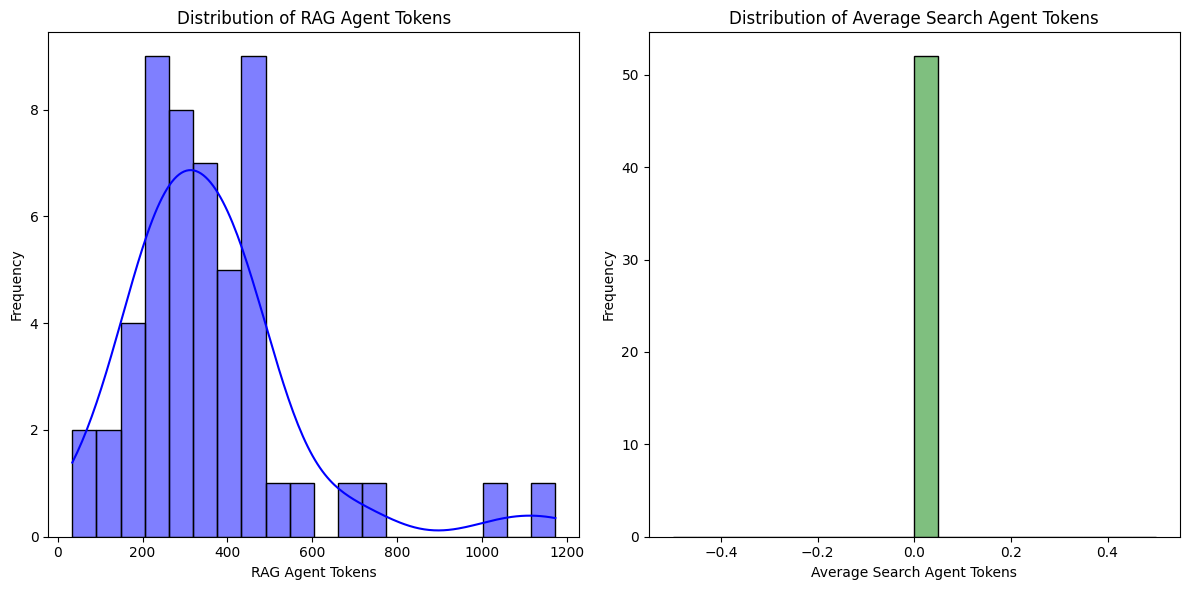

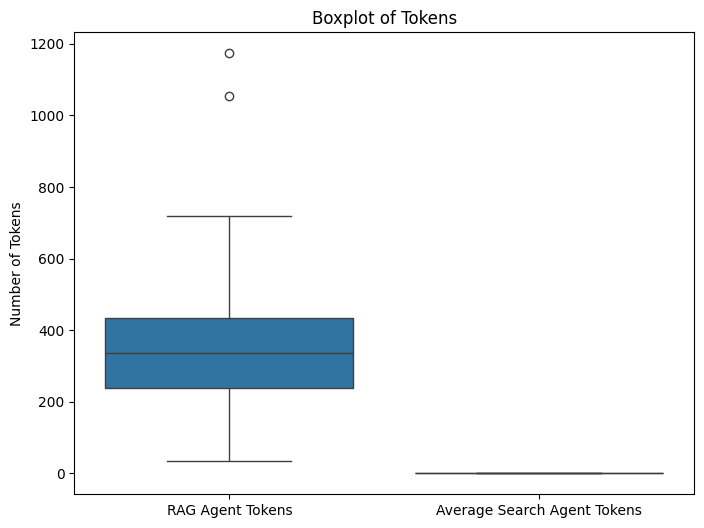

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter out rows with NaN values in 'rag_agent_tokens' or 'average_search_agent_token'
token_df_filtered = token_df.dropna(subset=['rag_agent_total_tokens', 'search_agent_total_tokens'])

# Set up the figure
plt.figure(figsize=(12, 6))

# Histogram for RAG Agent Tokens
plt.subplot(1, 2, 1)
sns.histplot(token_df_filtered['rag_agent_total_tokens'], bins=20, kde=True, color='blue')
plt.title('Distribution of RAG Agent Tokens')
plt.xlabel('RAG Agent Tokens')
plt.ylabel('Frequency')

# Histogram for Average Search Agent Tokens
plt.subplot(1, 2, 2)
sns.histplot(token_df_filtered['search_agent_total_tokens'], bins=20, kde=True, color='green')
plt.title('Distribution of Average Search Agent Tokens')
plt.xlabel('Average Search Agent Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplot for comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=token_df_filtered[['rag_agent_total_tokens', 'search_agent_total_tokens']])
plt.title('Boxplot of Tokens')
plt.ylabel('Number of Tokens')
plt.xticks([0, 1], ['RAG Agent Tokens', 'Average Search Agent Tokens'])
plt.show()